# Your Final Project Title

- Member 1: Caren Chua
- Member 2: Abby Salas 
- Member 3: Courtney Collins
- Member 4: Arggin Avanessian

In [88]:
!pip install nltk

In [89]:
!pip install textblob

In [90]:
!pip install gensim

In [91]:
!pip install wordcloud

In [92]:
# Importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora, models
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

## Introduction

## Research Question

1. Are more negative comments getting more engagement?
2. What is the optimal time to post to reach the largest audience on this subreddit

## Dataset Description

In [93]:
# Read and describe .csv file
df = pd.read_csv('reddit_vm.csv')
print(df.describe())

             score    comms_num       created
count  1602.000000  1602.000000  1.602000e+03
mean      3.686642     1.838951  1.547197e+09
std      29.915671    16.115147  7.099511e+07
min     -12.000000     0.000000  1.389595e+09
25%       1.000000     0.000000  1.554367e+09
50%       1.000000     0.000000  1.569226e+09
75%       3.000000     1.000000  1.584901e+09
max    1187.000000   595.000000  1.640822e+09


In our pursuit of answering the research question, we aimed to ensure a comprehensive and thorough analysis. As previously established, the primary objective of our research is to evaluate the impact of comments in terms of their emotional tone. Therefore, conducting a sentiment analysis was the most suitable approach for this evaluation. Consequently, we performed two sentiment analysis, one for the titles and another for the content of the posts themselves. Analyzing the sentiment of titles is crucial because they provide a preview of the post's content, despite potential variations in emotional tone between the titles and the actual post content. This approach allowed us to identify any inconsistencies in emotional tone between the two. It is important to consider this aspect since many titles are intentionally created as click bait to generate attention and traction, which is a prevalent phenomenon in the digital era.Moreover, the two sentiment analysis were necessary to examine the relationship between emotional tones and engagement. By evaluating the sentiment of titles and content separately, we could determine whether negative comments genuinely drive more engagement or if our hypothesis is flawed. Comparing the sentiment scores of negative comments with engagement metrics, such as upvotes, enabled us to establish a more accurate correlation between negative sentiment and increased engagement.

## Preprocessing

In [94]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


In [95]:
# Remove duplicates
df = df.drop_duplicates()

In [96]:
# Remove missing rows
df = df.dropna()

In [97]:
# Remove symbols from text data
df['body'] = df['body'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [98]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [99]:
# Remove stop words from text data
stop_words = set(stopwords.words('english'))
df['body'] = df['body'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [100]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
7,Fuck antivaxxing retards,10,g6jkhp,https://www.reddit.com/r/VaccineMyths/comments...,8,1.587663e+09,httpsyoutubezBkVCpbNnkU,2020-04-23 20:23:42
119,biologically possible insert 5G tracker human ...,9,khzpug,https://www.reddit.com/r/VaccineMyths/comments...,9,1.608647e+09,Although dont believe true COVID19 vaccine rec...,2020-12-22 16:19:39
134,dont see reason trust JJ vaccine,0,ocj9ws,https://www.reddit.com/r/VaccineMyths/comments...,4,1.625288e+09,company knew asbestos products aimed mothers b...,2021-07-03 07:57:05
145,Vaccine Survey,0,ak5ziq,https://www.reddit.com/r/VaccineMyths/comments...,5,1.548543e+09,Hi guys wondering could help research project ...,2019-01-27 00:42:09
161,rant please,13,o6nqcm,https://www.reddit.com/r/VaccineMyths/comments...,1,1.624488e+09,sure sub allows need vent need sanity right po...,2021-06-24 01:35:24


### Preprocessing Summary:

Firstly, we removed all duplicate rows to ensure that each comment was unique, avoiding any bias that may result from duplicate data. By ensuring that each comment is only considered once in the analysis, we prevent any skew in the results and maintain the integrity of our findings. Additionally, removing rows with missing values was part of our preprocessing steps to ensure that the analysis is based on complete data. By removing these missing rows, we can ensure that our analysis is not compromised by incomplete information, which could introduce biases or affect the accuracy of our results.Regarding negative comments, the step to remove symbols such as punctuation marks is an extra measure to focus on the content of the comments themselves. Punctuation does not typically carry significant meaning in terms of sentiment analysis, so removing them allows us to better evaluate the sentiment of the comments without unnecessary noise from symbols. Lastly, removing common words or stop words, such as "a," "an," "the," etc., helps reduce noise and minimize the dimensionality of the text when evaluating sentiment. By eliminating these words, which do not typically contribute much to sentiment analysis, we can focus on the words that carry more weight in determining the sentiment and engagement of the comments. Overall, these preprocessing steps are crucial in evaluating the sentiment of comments on Reddit posts. They ensure data cleanliness, completeness, and relevance, allowing us to obtain meaningful insights into the relationship between negative comments and engagement.

## Analysis

In [53]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp,time,time_only,body_sentiment,title_sentiment,interaction
268,vaccines linked autism,11,cuzm3a,https://www.reddit.com/r/VaccineMyths/comments...,12,1.566683e+09,stemmed article published Dr Andrew Wakefield ...,2019-08-25 00:48:57,2019-08-25 00:48:57,12:00 AM,-0.8765,0.0000,23
281,Vacvimes cause Autism NEED READ,0,bigdzp,https://www.reddit.com/r/VaccineMyths/comments...,25,1.556487e+09,Everyone sub thats joke retarded Like sorry sa...,2019-04-29 00:36:17,2019-04-29 00:36:17,12:00 AM,-0.9022,0.0000,25
287,Herd Immunity really achievable,1,azlm88,https://www.reddit.com/r/VaccineMyths/comments...,17,1.552258e+09,1933 Dr Arthur W Hedrich health officer Chicag...,2019-03-11 00:51:42,2019-03-11 00:51:42,12:00 AM,0.9559,0.3804,18
145,Vaccine Survey,0,ak5ziq,https://www.reddit.com/r/VaccineMyths/comments...,5,1.548543e+09,Hi guys wondering could help research project ...,2019-01-27 00:42:09,2019-01-27 00:42:09,12:00 AM,0.6597,0.0000,5
292,podcast discussing vaccinations need help,5,ali5am,https://www.reddit.com/r/VaccineMyths/comments...,5,1.548886e+09,Hey podcast discussing vaccinations upcoming e...,2019-01-31 00:07:10,2019-01-31 00:07:10,12:00 AM,0.7334,0.4019,10


In [101]:
# Creating a new column that adds the number of comments and the number of upvotes to a overall "interactions" column
df['interaction'] = df['comms_num'] + df['score']

## Sentiment Analysis

In [102]:
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for body text
df['body_sentiment'] = df['body'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [103]:
# Calculate sentiment scores for title
df['title_sentiment'] = df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

## Visualizations

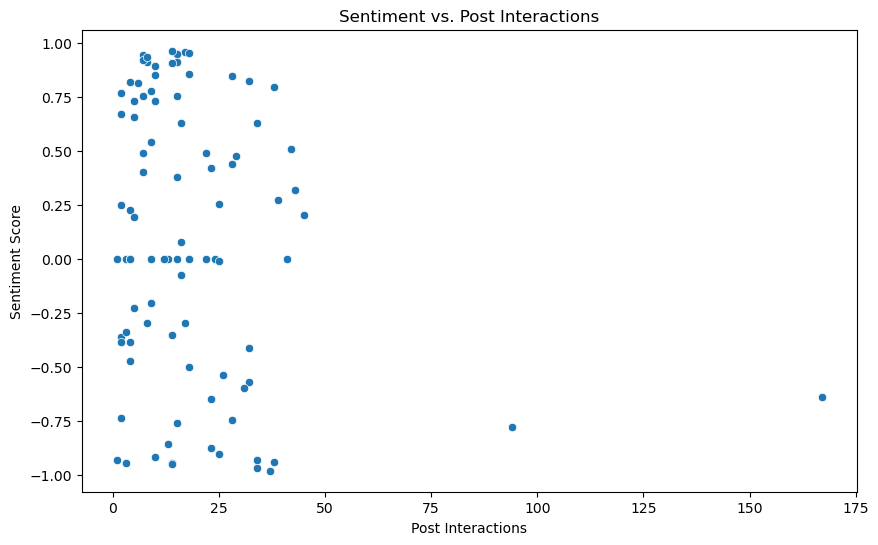

In [104]:
# Visualization: Body Sentiment vs. Upvotes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='interaction', y='body_sentiment', data=df)
plt.xlabel('Post Interactions')
plt.ylabel('Sentiment Score')
plt.title('Sentiment vs. Post Interactions')
plt.show()

### Visualization: Title Sentiment vs. Post Interactions (Comments & Upvotes

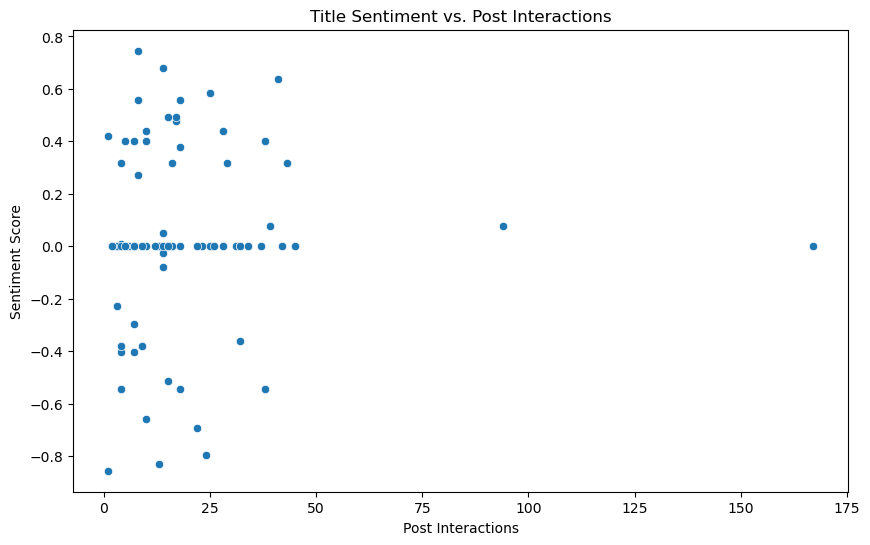

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='interaction', y='title_sentiment', data=df)
plt.xlabel('Post Interactions')
plt.ylabel('Sentiment Score')
plt.title('Title Sentiment vs. Post Interactions')
plt.show()

In [62]:
# Adding a new column that converts the 'timestamp' column to include only the time
df['time'] = pd.to_datetime(df['timestamp'])

In [63]:
# Create a new column with only the times
df['time_only'] = df['time'].dt.hour

In [64]:
# Convert the hours to standard time format
df['time_only'] = df['time_only'].apply(lambda x: pd.to_datetime(x, format='%H').strftime('%I:%M %p'))

In [65]:
time_order = ['12:00 AM', '1:00 AM', '2:00 AM', '3:00 AM', '4:00 AM', '5:00 AM', '6:00 AM', '7:00 AM',
                '8:00 AM', '9:00 AM', '10:00 AM', '11:00 AM', '12:00 PM', '1:00 PM', '2:00 PM', '3:00 PM',
                '4:00 PM', '5:00 PM', '6:00 PM', '7:00 PM', '8:00 PM', '9:00 PM', '10:00 PM', '11:00 PM']
df['time_only'] = pd.Categorical(df['time_only'], categories=time_order, ordered=True)

In [66]:
df = df.sort_values('time_only')

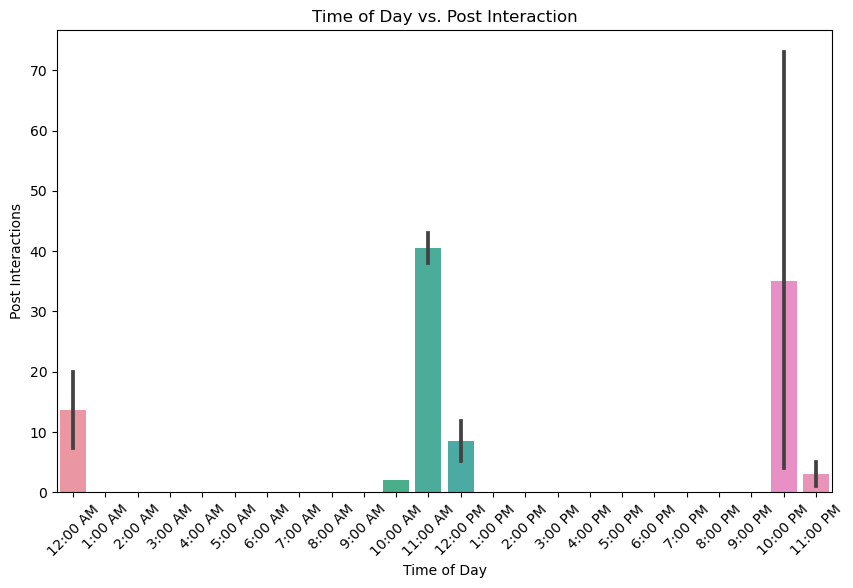

In [73]:
# Visualization: Body Sentiment vs. Upvotes

plt.figure(figsize=(10, 6))
sns.barplot(x='time_only', y='interaction', data=df)
plt.xlabel('Time of Day')
plt.ylabel('Post Interactions')
plt.xticks(rotation=45)
plt.title('Time of Day vs. Post Interaction')
plt.show()

## Results/Findings

## Contribution